In [1]:
import os
import csv

from PIL import Image as im

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import Accuracy, MeanMetric
from tqdm import tqdm

In [2]:
class PLDataModule(pl.LightningDataModule):
    def __init__(self, data_root, img_size, batch_size=32, train_split=0.8, num_workers=4):
        super().__init__()
        self.root = data_root
        self.metadata = self.get_metadata()
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_split = train_split
        self.num_workers = num_workers
        self.train_mean = [0.0, 0., 0.0]
        self.train_std = [1.0, 1.0, 1.0]
        self.common_transforms = transforms.Compose([
            transforms.Resize((img_size + 20, img_size + 20), 
                              transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            
        ])
        
    
    def prepare_data_per_node(self):
        # There is nothing to prepare.
        # The data should have already been downloaded and
        # extracted in the data_root that is passed to initiaize this class
        print(os.path.abspath(self.root))
        
    
    def setup(self, stage='fit'):
        data_dict = self.get_img_path_labels(stage)
        imgs_ct = len(data_dict['image_path'])
        imgs_tensor = torch.empty([imgs_ct, 3, self.img_size, self.img_size])
        labels_tensor = torch.empty(imgs_ct, dtype=int)
       
        for i in range(imgs_ct):
            img = im.open(data_dict['image_path'][i]).convert("RGB")
            img = self.common_transforms(img)
            imgs_tensor[i] = img
            labels_tensor[i] = data_dict['label'][i]
        
        if stage == 'fit':
            self.mean, self.std = self.compute_mean_std(imgs_tensor)
            imgs_tensor = transforms.functional.normalize(imgs_tensor, self.mean, self.std)
            final_dataset = tuple(map(lambda x, y: (x, y,), imgs_tensor, labels_tensor))
            train_split = torch.ceil(torch.tensor(imgs_ct * self.train_split)).to(int).item()
            self.train_set, self.val_set = random_split(final_dataset, [train_split, imgs_ct-train_split])
        else:
            imgs_tensor = transforms.functional.normalize(imgs_tensor, self.mean, self.std)
            self.test_set = tuple(map(lambda x, y: (x, y), imgs_tensor, labels_tensor))
            
    
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    
    #############################
    ## Miscellaneous functions ##
    #############################
    def compute_mean_std(self, image_tensor):
        axes = (0,2,3)
        return image_tensor.mean(axis=axes), image_tensor.std(axis=axes)
        
    def get_img_path_labels(self, stage='fit'):
        data_dict = {'image_path':[], 'label':[]}
        if stage == 'fit':
            dir_ = os.path.join(self.root, 'training', 'training')
        else:
            dir_ = os.path.join(self.root, 'validation', 'validation')
            
        for cl in self.metadata['Label']:
            class_path = os.path.join(dir_, cl)
            for img in os.listdir(class_path):
                if img.endswith(".jpg") or img.endswith(".png"):
                    fname = os.path.join(class_path, img)
                    data_dict['image_path'].append(fname)
                    data_dict['label'].append(int(cl[1]))
        
        return data_dict

    
    def get_metadata(self):
        metadata = dict()
        with open(os.path.join(self.root, 'monkey_labels.txt'), mode ='r') as file:
            csvFile = csv.reader(file)            
            headers = [r.strip() for r in  next(csvFile)]
            
            for h in headers:
                metadata[h] = []
                
            for lines in csvFile:
                for i in range(len(lines)):
                    metadata[headers[i]].append(lines[i].strip())
        return metadata

In [3]:
class MonkeyType(pl.LightningModule):
    def __init__(self, learning_rate=3e-4, num_classes=10, input_shape=10):
        super().__init__()        
        self.save_hyperparameters()
        
        # to log the model architecture on tensorboard
        self.example_input_array = torch.rand((1, 3, self.hparams.input_shape, self.hparams.input_shape))
        
        self.avg_pool = nn.AdaptiveAvgPool2d((5,5))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 5 * 5, self.hparams.num_classes)
        )
        
        # Model Metrics for logging
        acc_obj = Accuracy(num_classes=self.hparams.num_classes)
        # use .clone() so that each metric can maintain its own state
        self.train_acc = acc_obj.clone()
        self.val_acc = acc_obj.clone()
        
        loss_obj = MeanMetric()
        self.train_loss = loss_obj.clone()
        self.val_loss = loss_obj.clone()
        # End Model Metrics for logging
        
    def forward(self, x):
        x = self.avg_pool(x)
        x = self.fc(x)
        return x
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
    def on_train_epoch_start(self):
        super().on_train_epoch_start()

        # Reset state variables for train metrics to 
        # their default values before start of each epoch
        self.train_acc.reset()
        self.train_loss.reset()

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        pred = self(imgs)
        loss = F.cross_entropy(pred, labels)
        probs = F.softmax(pred, dim=1)
        pred_classes = probs.argmax(dim=1)
        
        # accumulate training accuracy for each batch
        acc = self.train_acc(pred_classes, labels)
        # accumulate training loss for each batch
        self.train_loss(loss)
        
        self.log("train/batch_loss", loss, prog_bar=False)
        self.log("train/batch_acc", acc, prog_bar=False)

        return loss
    
    def training_epoch_end(self, training_step_outputs):
        avg_train_acc = self.train_acc.compute()
        avg_train_loss = self.train_loss.compute()
        self.log("train/loss", avg_train_loss, prog_bar=True)
        self.log("train/acc", avg_train_acc, prog_bar=True)
        # Set X-axis as epoch number for epoch-level metrics
        self.log("step", float(self.current_epoch))
        
    def on_validation_epoch_start(self):
        super().on_validation_epoch_start()

        # Reset state variables for validation metrics to 
        # their default values before start of each epoch

        self.val_acc.reset()
        self.val_loss.reset()
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        output = self(imgs)
        loss = F.cross_entropy(output, labels)
        prob = F.softmax(output, dim=1)
        pred_classes = prob.argmax(dim=1)
        
        # accumulate validation accuracy for each batch
        self.val_acc(pred_classes, labels)
        self.val_loss(loss)
        
        return loss
    
    def validation_epoch_end(self, validation_step_outputs):
        avg_val_loss = self.val_loss.compute()
        avg_val_acc = self.val_acc.compute()
        self.log('val/loss', avg_val_loss, prog_bar=True)
        self.log('val/acc', avg_val_acc, prog_bar=True)
        self.log("step", float(self.current_epoch))
        
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        pred = self(imgs)
        loss = F.cross_entropy(pred, labels)
        prob = F.softmax(pred, dim=1)
        pred_classes = prob.argmax(dim=1)
        test_acc = torch.where(pred_classes == labels, 1, 0).to(torch.float32).mean()
        self.log('test/loss', loss)
        self.log('test/acc', test_acc)
        
    

In [4]:
pl.seed_everything(10, workers=True)
image_size = 32
m = MonkeyType(input_shape=image_size)
d = PLDataModule('./../monkeys/', img_size=image_size, batch_size=32, train_split=0.80, num_workers=4)

Global seed set to 10


In [5]:
logger = TensorBoardLogger("tb_logs", name="my_model", log_graph=True, default_hp_metric=False)
trainer = pl.Trainer(accelerator='cpu',
                     devices=1,
                     fast_dev_run=False,
                     enable_progress_bar=True,
                     enable_checkpointing=False,
                     enable_model_summary=True,
                     deterministic=True,
                     logger=logger,
                     log_every_n_steps=20,
                     max_epochs=20,
                     check_val_every_n_epoch=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(m, d)

Missing logger folder: tb_logs/my_model

  | Name       | Type              | Params | In sizes       | Out sizes   
---------------------------------------------------------------------------------
0 | avg_pool   | AdaptiveAvgPool2d | 0      | [1, 3, 32, 32] | [1, 3, 5, 5]
1 | fc         | Sequential        | 760    | [1, 3, 5, 5]   | [1, 10]     
2 | train_acc  | Accuracy          | 0      | ?              | ?           
3 | val_acc    | Accuracy          | 0      | ?              | ?           
4 | train_loss | MeanMetric        | 0      | ?              | ?           
5 | val_loss   | MeanMetric        | 0      | ?              | ?           
---------------------------------------------------------------------------------
760       Trainable params
0         Non-trainable params
760       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [7]:
trainer.test(m, d)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.3970588147640228
        test/loss            1.839987874031067
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 1.839987874031067, 'test/acc': 0.3970588147640228}]

patas_monkey
erythrocebus_patas


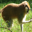

In [8]:
ds = d.train_dataloader()
dsi = iter(ds)
ds1 = next(dsi)
a, b = ds1
idx = torch.randint(0, 20, (1,)).item()
a = ((a[idx].permute(1,2,0) * d.std + d.mean) * 255).clamp(0, 255).to(torch.uint8).numpy()
print(d.metadata['Common Name'][int(b[idx])])
print(d.metadata['Latin Name'][int(b[idx])])
im.fromarray(a)